In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix

import tensorflow
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout



sys.path.append("../Shared/")
from DataService import DataService

sys.path.append("../Datasets/")
from DataCreation import getDatasetV1, getDatasetV2, getDatasetV3



/tmp/ipykernel_104878/895462022.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-21 02:59:49.151727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 02:59:49.641236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

2023-07-21 02:59:50.127202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-21 02:59:50.163123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-21 02:59:50.163516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### getting data

In [3]:
months = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [4]:
df = getDatasetV1(months)
df['has_ergot'] = df['has_ergot'].astype(int) # 0: Flase, 1: True
df

,year,district,mean_snow_on_grnd,mean_total_rain,mean_total_precip,mean_temp,mean_total_snow,has_ergot
0,1995,4860,7.397947,0.127390,0.703097,-8.308038,0.508508,0
1,1995,4810,2.347283,0.202391,0.699891,-3.942174,0.246685,0
2,1995,4840,4.026087,0.023587,0.434457,-7.018804,0.272428,1
3,1995,4830,3.204903,0.069559,0.866053,-3.630185,0.272457,1
4,1995,4731,0.000000,0.000000,0.532790,-4.529529,0.000000,1
...,...,...,...,...,...,...,...,...
1059,2022,4605,8.217391,0.000000,0.675000,-6.471739,0.000000,1
1060,2022,4720,7.521739,0.000000,0.259239,-5.984783,0.000000,1
1061,2022,4611,3.836957,0.000000,0.805435,-3.959783,0.000000,1
1062,2022,4751,3.641304,0.000000,0.770652,-6.557609,0.000000,1


### splitting data

In [5]:
# split data into train, validate and test
TARGET = 'has_ergot'
PIVOT = 2019

In [6]:
# split datframe till 2018
df_train = df[df['year'] < PIVOT]
df_train.drop(columns=['year', 'district'], inplace=True)
X_train_df = df_train.drop(columns=[TARGET])
y_train_df = df_train[TARGET]

# X_train_df

/tmp/ipykernel_104878/1330982459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year', 'district'], inplace=True)


In [7]:
#split dataframe from 2019
df_test = df[df['year'] >= PIVOT]
df_test.drop(columns=['year', 'district'], inplace=True)
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

# X_test

/tmp/ipykernel_104878/910238129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['year', 'district'], inplace=True)


In [8]:
# now we treat the train data as a whole and split it into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

### scaling and oversampling

In [9]:
# normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# oversampling data
ros = RandomOverSampler(random_state=42)
X_train_rs, y_train_rs = ros.fit_resample(X_train, y_train)

### Model

In [20]:
model = Sequential()

layers_node = [128,64,1] #[64, 16, 8, 4, 1]

model.add(Dense(48, activation='relu' ,input_dim=X_train.shape[1])) #, kernel_regularizer=l2(0.01)
# model.add(Dense(32, activation='relu')) #, kernel_regularizer=l2(0.01)
# model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(48, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # , kernel_regularizer=l2(0.01)

# for i in range(len(layers_node)):
#     if i == 0:
#         model.add(Dense(layers_node[i], activation='relu', kernel_regularizer=l2(0.01) ,input_dim=X_train.shape[1])) #, kernel_regularizer=l2(0.01)
#     elif(i == len(layers_node) - 1):
#         model.add(Dense(layers_node[i], kernel_regularizer=l2(0.01), activation='sigmoid')) # , kernel_regularizer=l2(0.01)
#     elif(i%2 == 0):
#         model.add(Dropout(0.2))
#     else:
#         model.add(Dense(layers_node[i], kernel_regularizer=l2(0.01), activation='relu'))
        

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 48)                288       
                                                                 
 dense_6 (Dense)             (None, 48)                2352      
                                                                 
 dense_7 (Dense)             (None, 48)                2352      
                                                                 
 dense_8 (Dense)             (None, 48)                2352      
                                                                 
 dense_9 (Dense)             (None, 1)                 49        
                                                                 
Total params: 7,393
Trainable params: 7,393
Non-trainable params: 0
_________________________________________________________________


In [22]:
# history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_data=(X_val, y_val), verbose=1)
history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/500


30/30 [==============================] - 1s 4ms/step - loss: 0.6588 - accuracy: 0.6328 - val_loss: 0.9299 - val_accuracy: 0.0958
Epoch 2/500
30/30 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.6517 - val_loss: 1.0406 - val_accuracy: 0.1292
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 0.6078 - accuracy: 0.6548 - val_loss: 0.9804 - val_accuracy: 0.1750
Epoch 4/500
30/30 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.6810 - val_loss: 0.8748 - val_accuracy: 0.3250
Epoch 5/500
30/30 [==============================] - 0s 2ms/step - loss: 0.5785 - accuracy: 0.7040 - val_loss: 0.9502 - val_accuracy: 0.3667
Epoch 6/500
30/30 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.7249 - val_loss: 0.9459 - val_accuracy: 0.3333
Epoch 7/500
30/30 [==============================] - 0s 2ms/step - loss: 0.5589 - accuracy: 0.7280 - val_loss: 0.8691 - val_accuracy: 0.5000
Epoch 8/500
30/30 [======

In [23]:
def evaluate_model(history):
    # Get the training and validation loss from the history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    # Check if the model is overfitting, underfitting, or performing well
    # final_training_loss = np.array(training_loss).mean()
    # final_validation_loss = np.array(validation_loss).mean()

    # final_training_accuracy = np.array(training_accuracy).mean()
    # final_validation_accuracy = np.array(validation_accuracy).mean()

    # if final_training_loss < final_validation_loss:
    #     print("The model is likely underfitting.")
    # elif final_training_loss > final_validation_loss:
    #     print("The model is likely overfitting.")
    # else:
    #     print("The model is performing well and generalizing to new data.")

    # if final_training_accuracy == 1.0 and final_validation_accuracy == 1.0:
    #     print("The model has achieved 100% accuracy on both training and validation data.")

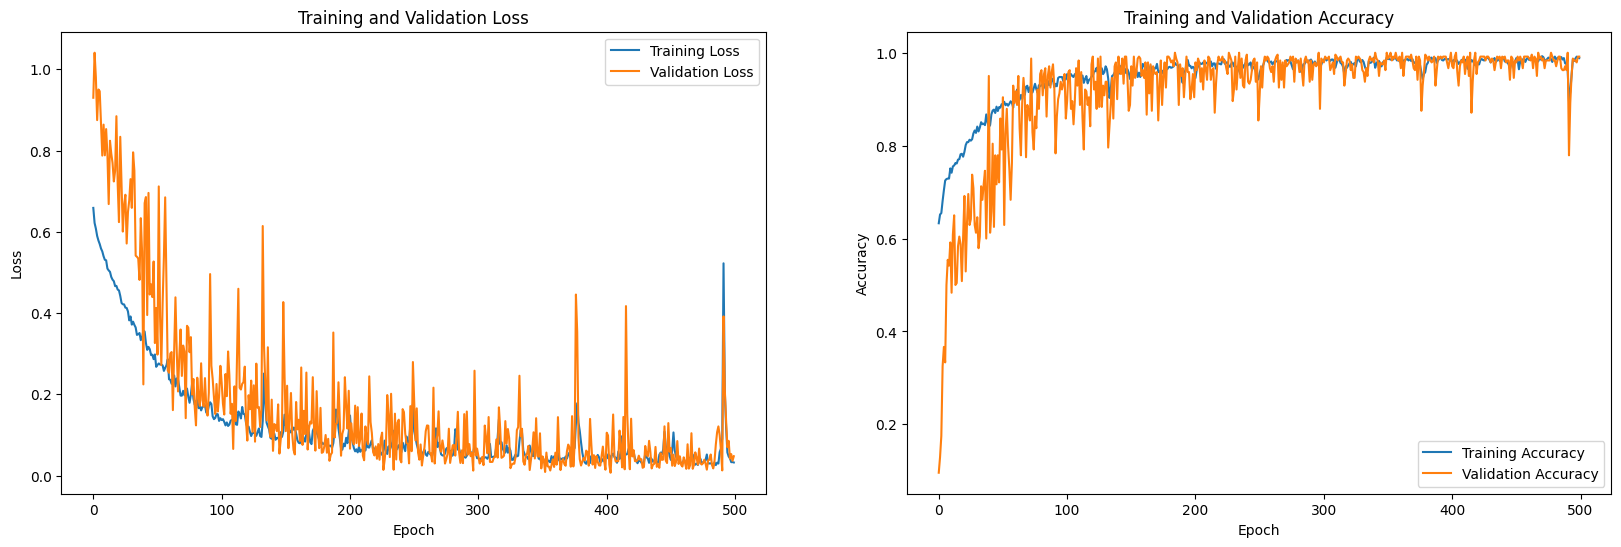

In [24]:
evaluate_model(history)

###  pred

In [25]:
y_log = model.predict(X_val)
y_pred = np.where(y_log > 0.5, 1, 0)

6/6 [==============================] - 0s 673us/step


In [26]:
conf_matrix = confusion_matrix(y_val, y_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_val, y_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_val, y_pred))

Accuracy:  0.8032786885245902
Precision:  0.8662420382165605
Recall:  0.9006622516556292
F1 Score:  0.8831168831168832
AUC Score:  0.6222061258278146


# d1
[64, 16, 8, 4, 1]
- Accuracy:  0.7759562841530054
- Precision:  0.8767123287671232
- Recall:  0.847682119205298
- F1 Score:  0.861952861952862
- AUC Score:  0.642591059602649

In [28]:
# main prediction

y_main_log = model.predict(X_test)
y_main_pred = np.where(y_main_log > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_main_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_main_pred)
print("AUC Score: ", auc_score)

print(classification_report(y_test, y_main_pred))

5/5 [==============================] - 0s 857us/step


Accuracy:  0.75
Precision:  0.7985611510791367
Recall:  0.9173553719008265
F1 Score:  0.8538461538461539
AUC Score:  0.5070647827246068
              precision    recall  f1-score   support

           0       0.23      0.10      0.14        31
           1       0.80      0.92      0.85       121

    accuracy                           0.75       152
   macro avg       0.51      0.51      0.50       152
weighted avg       0.68      0.75      0.71       152



### get weights

In [18]:
def plot_feature_importance(model, feature_names):
    # Get the weights of the first hidden layer
    first_hidden_layer_weights = model.layers[0].get_weights()[0]
    
    # Calculate the mean absolute weight for each feature
    feature_importance = np.mean(np.abs(first_hidden_layer_weights), axis=1)
    
    # Sort the features based on their importance
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_names)), sorted_feature_importance)
    plt.xticks(range(len(feature_names)), sorted_feature_names, rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance of MLP')
    plt.tight_layout()
    plt.show()


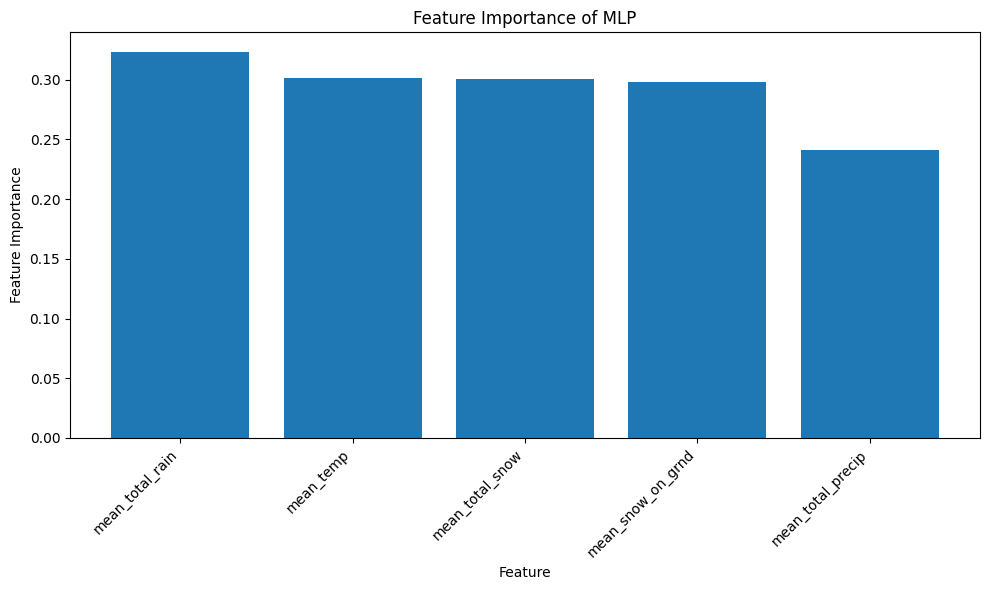

In [19]:
plot_feature_importance(model, X_train_df.columns)